# <div align="center">TP n° : Introduction to geomagnetism and models building</div>


## 1 Introduction


Earth's magnetic field, also known as the geomagnetic field, is the magnetic field that extends from Earth's interior out into space. It is the resultant of differents sources of magnetic field, it mainly results from the iron motions in the Earth's core, its intensity vary between 30 000 and 60 000 nT.
These convection currents are caused by heat escaping from the core, a natural process called a geodynamo.

Earth's magnetic field sources can be divided in two categories : the interior and exterior sources. The interior sources are the iron motions in the Earth's core, the current passing through the mantle, the permanent magnetized materials in the crust, the charged particules motions in the oceans etc... 
The external sources are all the sources further away from the Earth's crust like the charged particles in the ionosphere and in the magnetosphere, the charged particles emanating from the Sun etc...

Swarm is European Spatial Agency's first constellation mission for Earth's observation. It consists of three identical satellites called Alpha, Bravo and Charlie that orbits in low altitude at approximately 490 km altitude and deliver a detailed survey on the geomagnetic field. Its function is to provide data on the temporal evolution of the field and the electrical current in the atmosphere with magnetometers and other devices. Its objective is to study the core dynamic, mapping the litosphere's magnetisation, mapping in 3D the eletrical condictivity in the mantle, study the core-mantle interactions and so one. 
Swarm is a virtual observatory, a virtual observatory is a collection of data provided by differents sensors and researchers algorithms to study some phenomena. 
The geomagnetical virtual observatory product two different data, the "Observed Field" that estimate the magnetic field with all of its sources and the "Core Field" that adds differents filters to mask the contribution of charged particles in the atmosphere. 

## 2 Open the data from observatories 

The data we will use come from Swarm virtual observatory and ground observatories, these data are stored in *Computable Document Format* this format need to be openned with a python module called **cdflib**. We will use some of the function of this module to open the data file and create a dictionnary to find the data easily. The function we will use are : 
- **cdflib.CDF(path)** with which you can create a CDF class and that takes in argument the path of datas in your computer. 
- **cdf_file.cdf_info(name)** with which you get all the information from the CDF file.
- To create the dictionnary, you need to get the keys from the file with the function **info['zVariables']**. 
Finally, you can create the dictionnary : 

In [1]:
import cdflib 
import os
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.special import lpmv
import math
import h5py
import matplotlib

%run functions.py

cdf_dir = 'donnees/cdf_files_basic_sync_functions_201'
swarm_file = os.path.join(cdf_dir, 'SW_OPER_VOBS_4M_2__20140301T000000_20210701T000000_0201_basic_sync_functions.cdf')
cdf_read = cdflib.CDF(swarm_file)
info = cdf_read.cdf_info()
zvars = info['zVariables']
alldata = {name: cdf_read.varget(name) for name in zvars}
print('>' ,alldata.keys()) # These are the keys to use to extract all the different data from our files.

> dict_keys(['Timestamp', 'Latitude', 'Longitude', 'Radius', 'B_OB', 'sigma_OB', 'B_CF', 'sigma_CF', 'Timestamp_SV', 'B_SV', 'sigma_SV'])


Now we can observe all the different keys of the dictonnary we used to store the data :
- **'Timestamp'** refers to the time data.
- (**'Radius', 'Latitude', 'Longitudes**) refers to the localisation of our observatories.
- **'B_OB'** and **'sigma_OB'** refers to the raw observations and incertitudes. 
- **'B_CF'** and **'sigma_CF'** refers to the observations cleaned from the anomalies detected in the raw observations.
- the term **'SV'** refers to the secular variations.

The next step is to plot these observations, we will use the module **matplotlib.pyplot** and a module called **cartopy** that can plot an Earth's map. 

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]


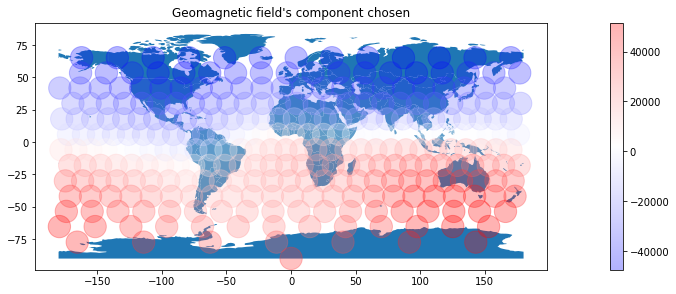

In [2]:
from functions import cdf_times_to_np_date, extract_MF_list, compute_unique_times_list

## Choice of the date and component
unique_times_list = cdf_times_to_np_date(compute_unique_times_list(alldata['Timestamp']))
print('unique times list >', unique_times_list)
date = '2017-09' # Arbitrary choice of the date to plot 
index_temps = np.argwhere((cdf_times_to_np_date(alldata['Timestamp'])) == np.datetime64(date))[0][0]
choice = 0 # Arbitrary choice of the component to plot 

## Creation of the different lists
N_VO = 300
latitudes = alldata['Latitude'][index_temps:index_temps+N_VO]
longitudes = alldata['Longitude'][index_temps:index_temps+N_VO]
MF = extract_MF_list(alldata['B_CF'][index_temps:index_temps+N_VO], choice)

## Lines plotting the geomagnetic field 
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax1=fig.add_subplot(221)
world.plot(ax=ax1)
map_cf = ax1.scatter(longitudes, latitudes, c=MF, s=500, alpha=0.3,cmap='bwr')
ax1.set_title("Geomagnetic field's component chosen")
plt.colorbar(map_cf, ax=ax1)
plt.show()

Note : For now, we did only use the core field data that are cleaned from the external sources. But you can change the key of the computed MF to 'B_OB' to see the non-cleared data from the external sources. 

## 3 Physical description of the problem 

### 3.1 Description of the problem

In areas between $R_{Earth}$ and $R_{ionosphere}$ where there are not electric current, the magnetic potential is solution of the Laplace's equation :$\nabla^2 V=0$. 

In spherical coordinates, the Laplacian operator can be written as follows : $\displaystyle \nabla^2 = \frac{2}{r}\frac{\delta}{\delta r}+\frac{\delta^2}{\delta r^2}+\frac{1}{r^2sin(\Theta)}\frac{\delta}{\delta \Theta}(\sin(\theta \frac{\delta}{\delta \Theta}))+ \frac{1}{r^2 \sin^2(\Theta)}\frac{\delta^2}{\delta \Phi^2}$.

We can solve this equation using spherical harmonics, we will get the following formula for the magnetic field created by the internal sources : 

<div align="center"> <mark> $ \displaystyle \Sigma_{n=1}^{\infty} (\frac{a}{r})^{n+1} \Sigma^n_{m=0} ( g_n^m \cos(m \Phi) + h_n^m \sin(m \Phi) ) P_n^m(\cos(\Theta))$ </mark> </div>

Then we can deduce the geomagnetical field on any place around Earth : 

<div align="center"> <mark>$ \displaystyle B_i(r, \Theta, \Phi) = \Sigma^\infty_{n=1} (\frac{a}{r})^{n+2} \Sigma^{n}_{m=0} (g_{n}^m \Pi^{mc}_{ni}(\Theta, \Phi) + h_n^m \Pi^{ms}_{ni}(\Theta, \Phi))$.</mark> </div>

*a is the reference radius chosen as $a=R_{earth}$, the $P_n^m$ are the Legendre associated polynomials functions that will be determined by one of the python code. $g^m_n,h^m_n,q_n^m,s_n^m$ are the the Gauss coefficient that will appear as the variables of our system when we will use the estimation by least square.$\Theta$ is the co-latitude and $\Phi$ is the longitude and, r is the geocentric distance.*

Solving this equation will be equivalent to solve the equation <mark>$Y = HX$</mark> *with **Y** the magnetic field's values, **H** a matrix depending on the positions and **X** the gauss's coefficients vector*.

To compute the **H** matrix, we will use the formulas of the vectors $\Pi^{mc}_{ni}$ and $\Pi^{ms}_{ni}$ that have the following forms : 

<div align="center"> <mark> $ \displaystyle \Pi^{mc}_{ni}(\Theta, \Phi) = (n+1)P^m_n(\cos(\Theta))\cos(m\Phi)e_r - \frac{d P^m_n(cos(\Theta))}{d\Theta}\cos(m\Phi) e_{\Theta}+\frac{m}{\sin(\Theta)}P^m_n(\cos(\Theta))\sin(m\Phi)e_{\Phi} $ </mark> </div>

<div align="center"> <mark> $ \displaystyle \Pi^{ms}_{ni}(\Theta, \Phi) = (n+1)P^m_n(\cos(\Theta))sin(m\Phi)e_r - \frac{d P^m_n(\cos(\Theta))}{d\Theta}\sin(m\Phi) e_{\Theta}+\frac{m}{\sin(\Theta)}P^m_n(\cos(\Theta))\cos(m\Phi)e_{\Phi} $ </mark> </div>


### 3.2 Solving the direct problem :

Now, you will try to compute the geomagnetic field using given gauss coefficients. We will use a model previously created that is called **CHAOS-7**. This model is determined using observations done by satellites *Swarm, CryoSat-2, Champ, SAC-C and  Ørsted* and with ground observatories. This model consist of time dependant internal field without degrees up to 20, the parameters were determinated using iteratively reweighted regularized least-squares procedure and using the previous CHAOS models. This model is used to investigate changes in the geomagnetic field. 

To compute the direct problem, we need to solve the equation $Y = HX$ using the CHAOS-7's gauss coefficient vector X. We will only work for now with the internal field's gauss coefficients. The H matrix is computed using the previous equations of $ \Pi^{mc}_{ni} $ and $ \Pi^{ms}_{ni}(\Theta, \Phi) $. 

To plot the geomagnetic field we will also use a python module called *geopandas* that can allow us to plot the Earth's map.

times chaos > [1997.5 1998.  1998.5 1999.  1999.5 2000.  2000.5 2001.  2001.5 2002.
 2002.5 2003.  2003.5 2004.  2004.5 2005.  2005.5 2006.  2006.5 2007.
 2007.5 2008.  2008.5 2009.  2009.5 2010.  2010.5 2011.  2011.5 2012.
 2012.5 2013.  2013.5 2014.  2014.5 2015.  2015.5 2016.  2016.5 2017.
 2017.5 2018.  2018.5 2019.  2019.5]


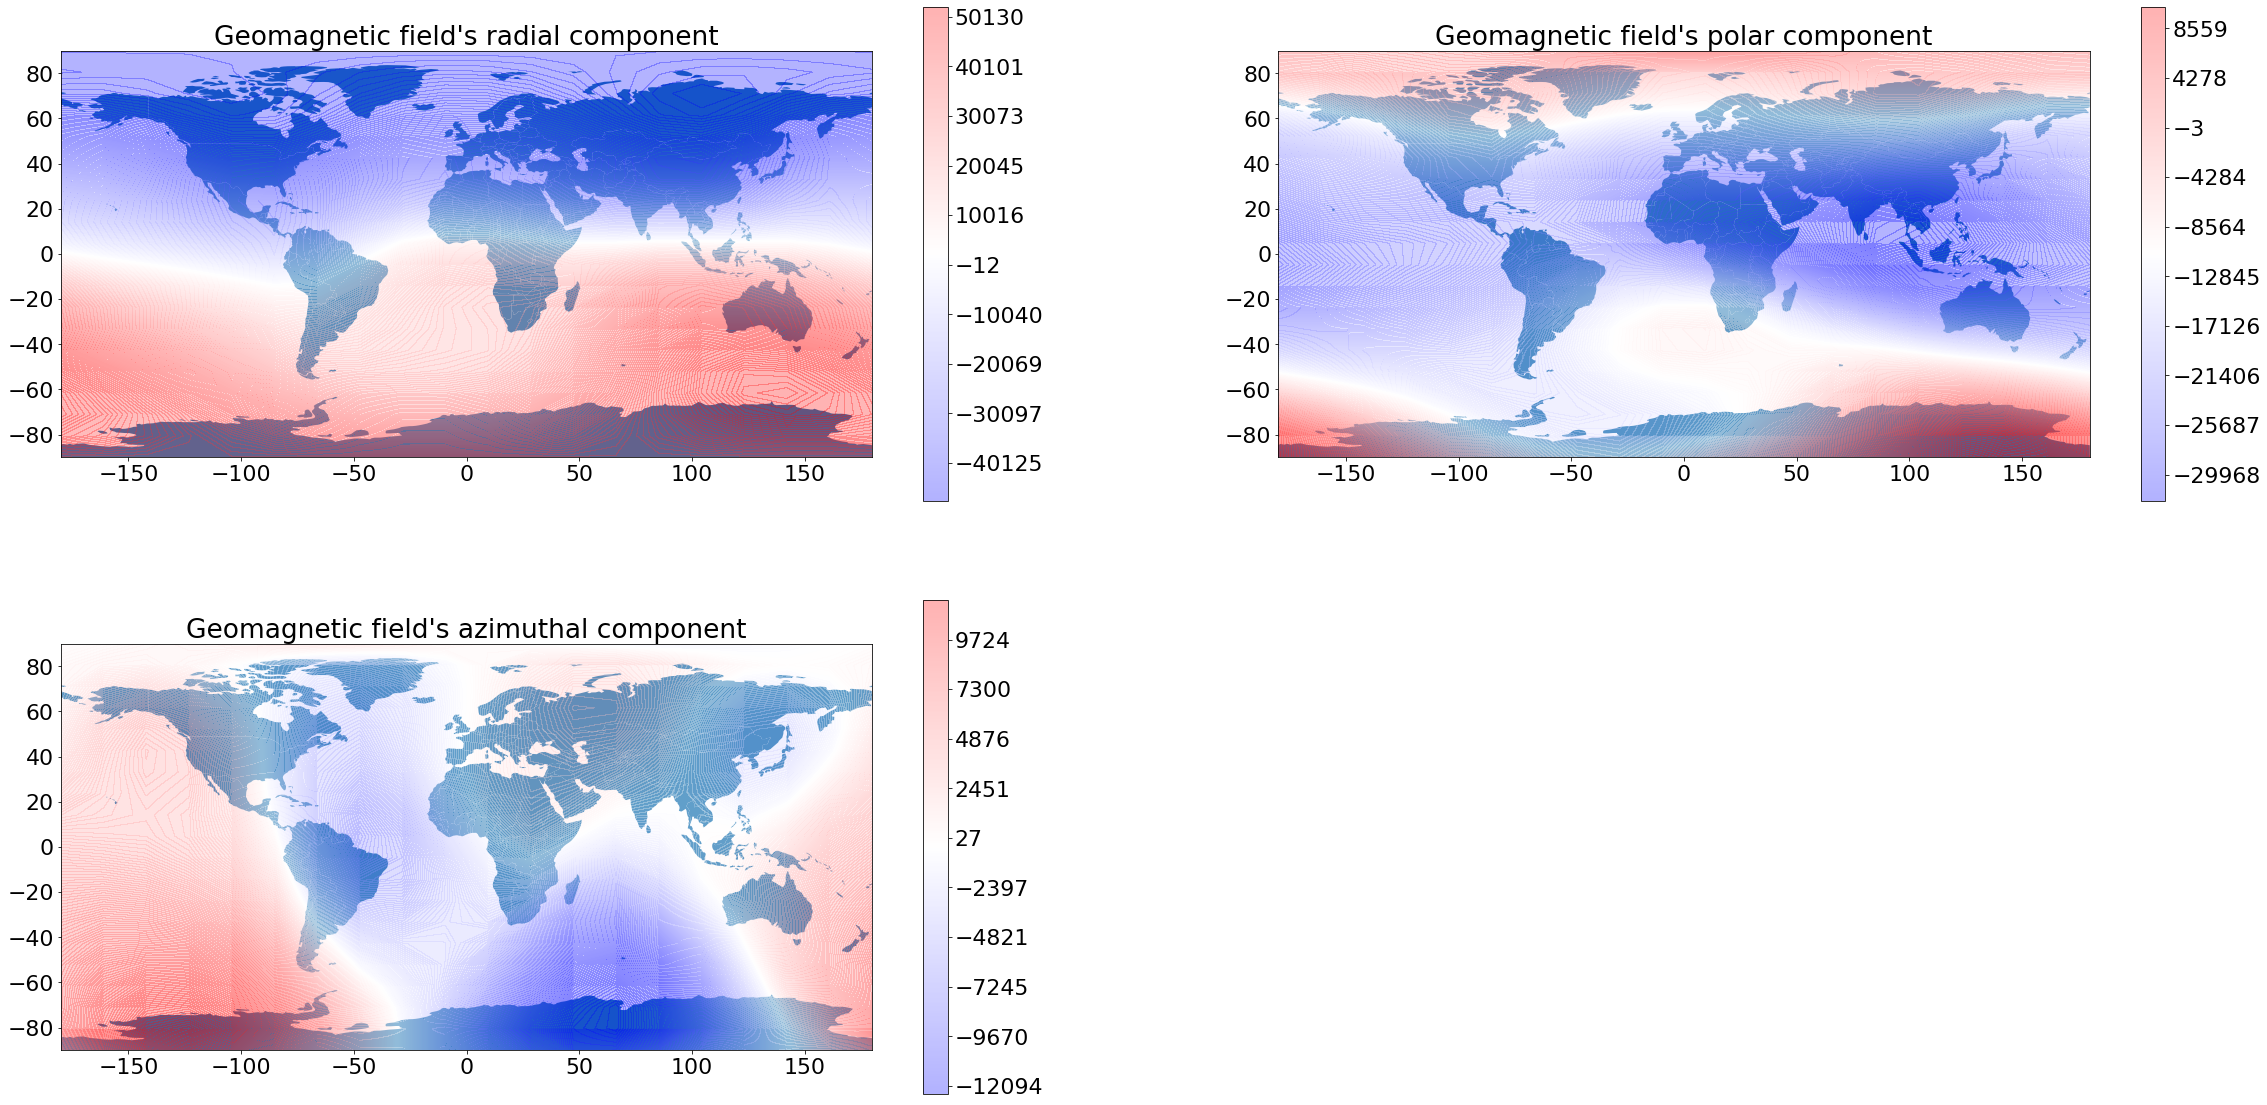

In [3]:
from functions import compute_B, compute_grid_positions, compute_B_meshgrid, create_graph 

# Extract the gauss coefficients matrix from the file 
with h5py.File('donnees/CHAOS-7.hdf5') as file:
    #  print(file.keys())
    gauss_coeffs = np.array(file['gnm'])
    times_chaos = np.array(file['times'])
# gauss_coeffs shape : (45 times, max_degree(max_degree+2)=440)
# times_chaos shape : 45 times (45,)

print('times chaos >', times_chaos)

# Graphs parameters 
font = {'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


# Variables choices
date = 2018.5 # see times_chaos values
radius = 6861 # radius of the swarm data but we can project these data

# Creation of the different lists
eps = 10e-7
N = 20 # number of different latitudes/longitudes for the grid
L_max = 20 # max degree used in our gauss coefs vector 
latitudes = np.linspace(0, 180, N)
longitudes = np.linspace(-180, 180, N)
th = 90 - latitudes + eps
ph = longitudes
positions = compute_grid_positions(radius, th, ph, N)
index_temps = np.argwhere(times_chaos == date)

# Creation of the MF list
B = compute_B(positions, N, L_max, gauss_coeffs[index_temps][0][0])

# Plotting the geomagnetic field estimated with chaos-7 gauss coefficients
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)
create_graph(fig, 221, world, th, ph, BR_meshgrid, "Geomagnetic field's radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Geomagnetic field's polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Geomagnetic field's azimuthal component")
plt.show()

### 3.3 Solving the inverse problem :

The next part of the practicium is to compute the inverse problem, using the least-square method and a model called the prior. We will create our own model using the geomagnetic field's observations. We need to maximize the probability of two gauss multivariable distributions : the product of the observations distributions and the prior normal distribution. 

After doing the demonstration, that is available on the written report, we can state that the gauss coefficient's vector **X** will have the following form : 
<div align="center"> <mark> $X = (\Sigma_P^{-1} + H^T \Sigma_{Obs}^{-1} H ) ^{-1} ( \Sigma_P^{-1} \mu_p +  H^T \Sigma_{Obs}^{-1} Y)$ </mark> </div>

with $\Sigma_P$ the covariance matrix of the prior model, $\mu_p$ its mean vector and $\Sigma_{Obs}$ the covariance matrix of the observations.

The prior's covariance matrix is given, the observations covariance matrix is computed with the data given by satellites. 

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]


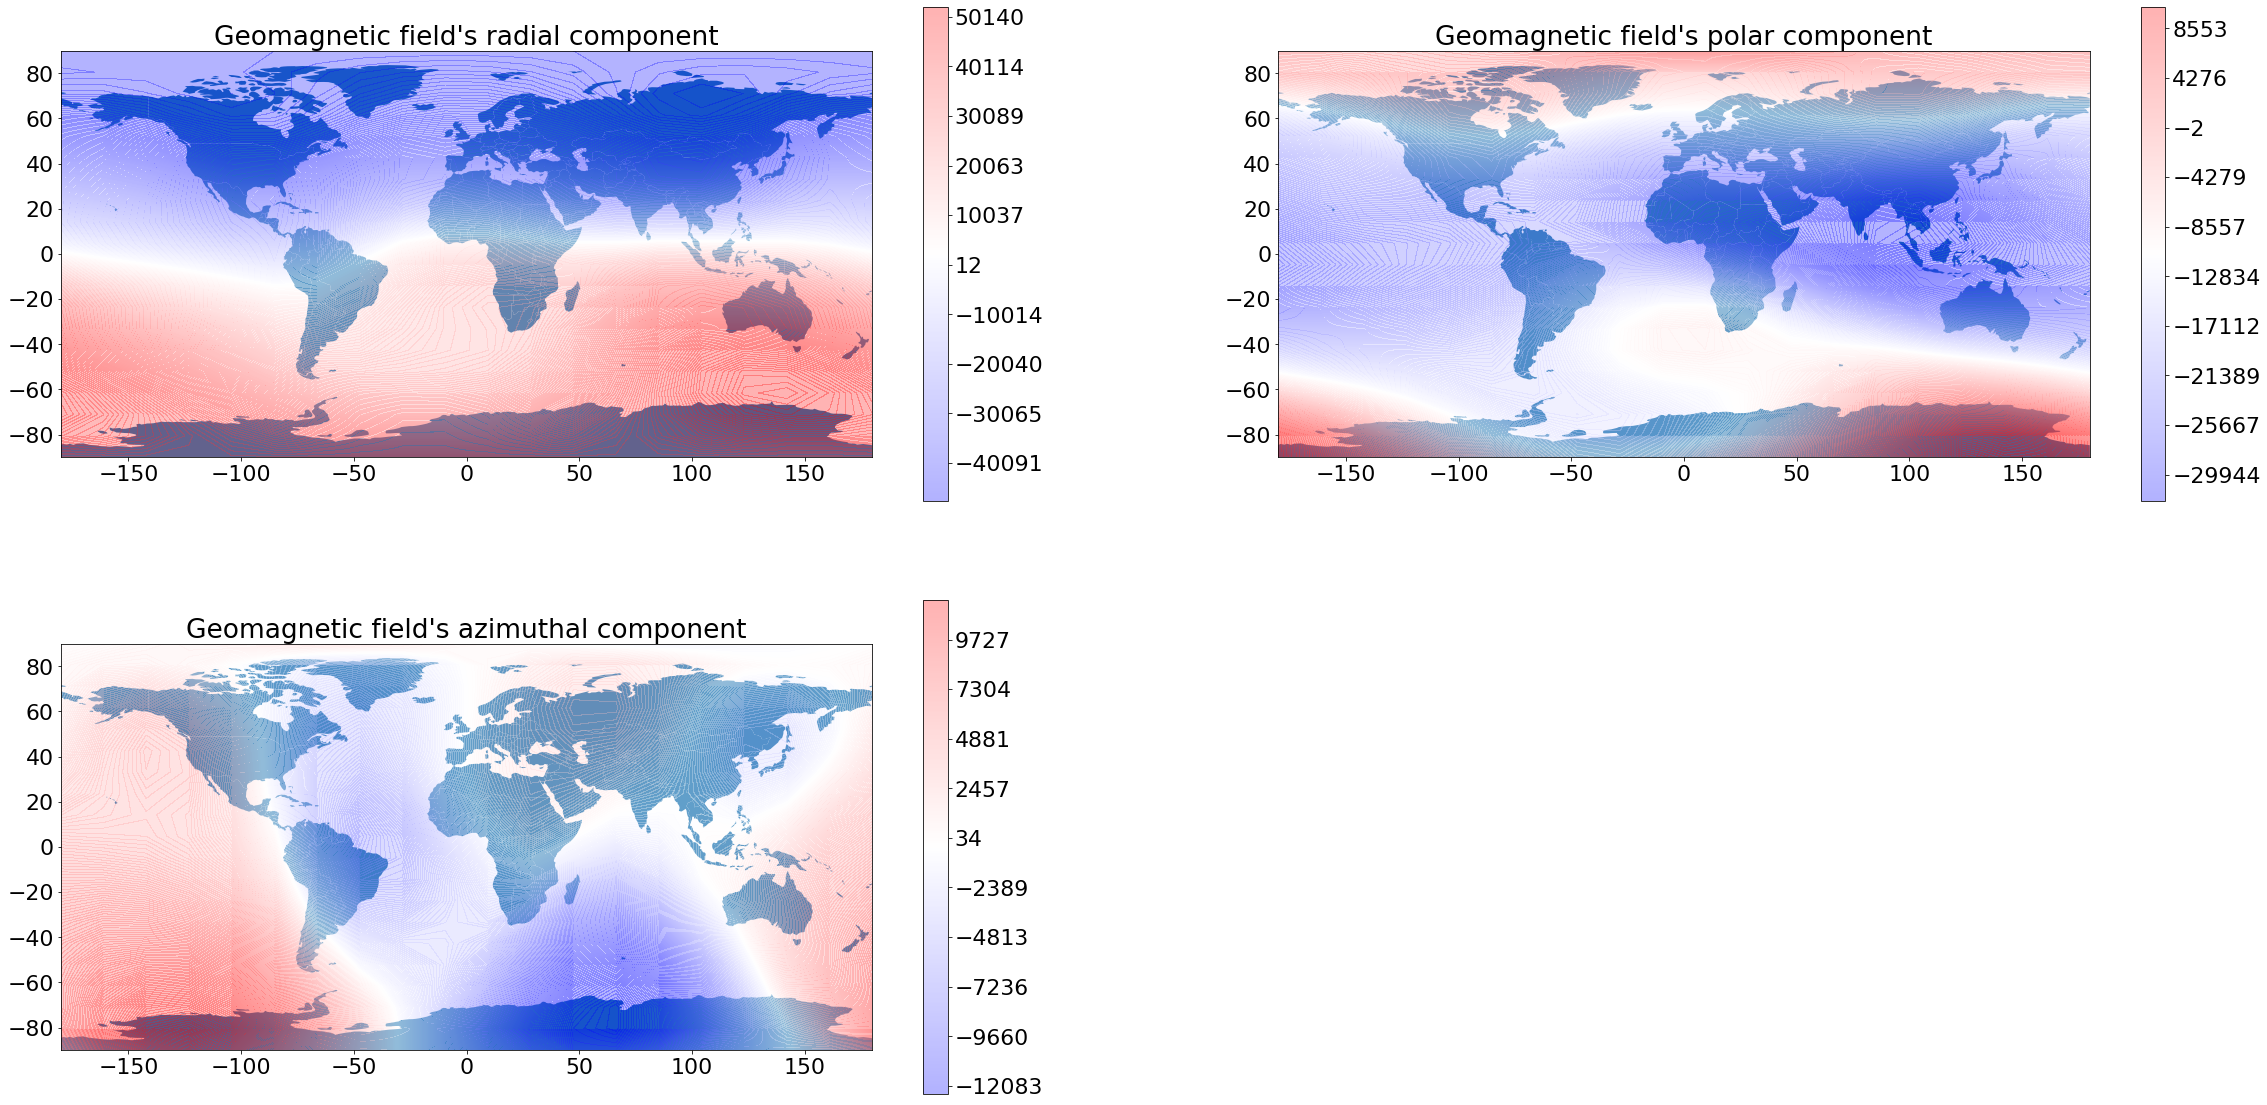

In [4]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'
radius = 6861

# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('prior_cov_matrix.txt')
cdf_dir = 'donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2017-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)


## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 20
th = np.linspace(-90+eps, 90+eps, N)
ph = np.linspace(-180, 180, N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  Lines plotting it
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "Geomagnetic field's radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Geomagnetic field's polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Geomagnetic field's azimuthal component")
plt.show()


### 3.4 Plotting the difference between the observed field and the core field 

Now we will try to use the raw data, these data can be extract for our file called *alldata* using the key **B_OB**. By solving the inverse problem and computing gauss coefficients using geomagnetic field observations, we can compute the MF using raw and cleaned data to compare them.

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]


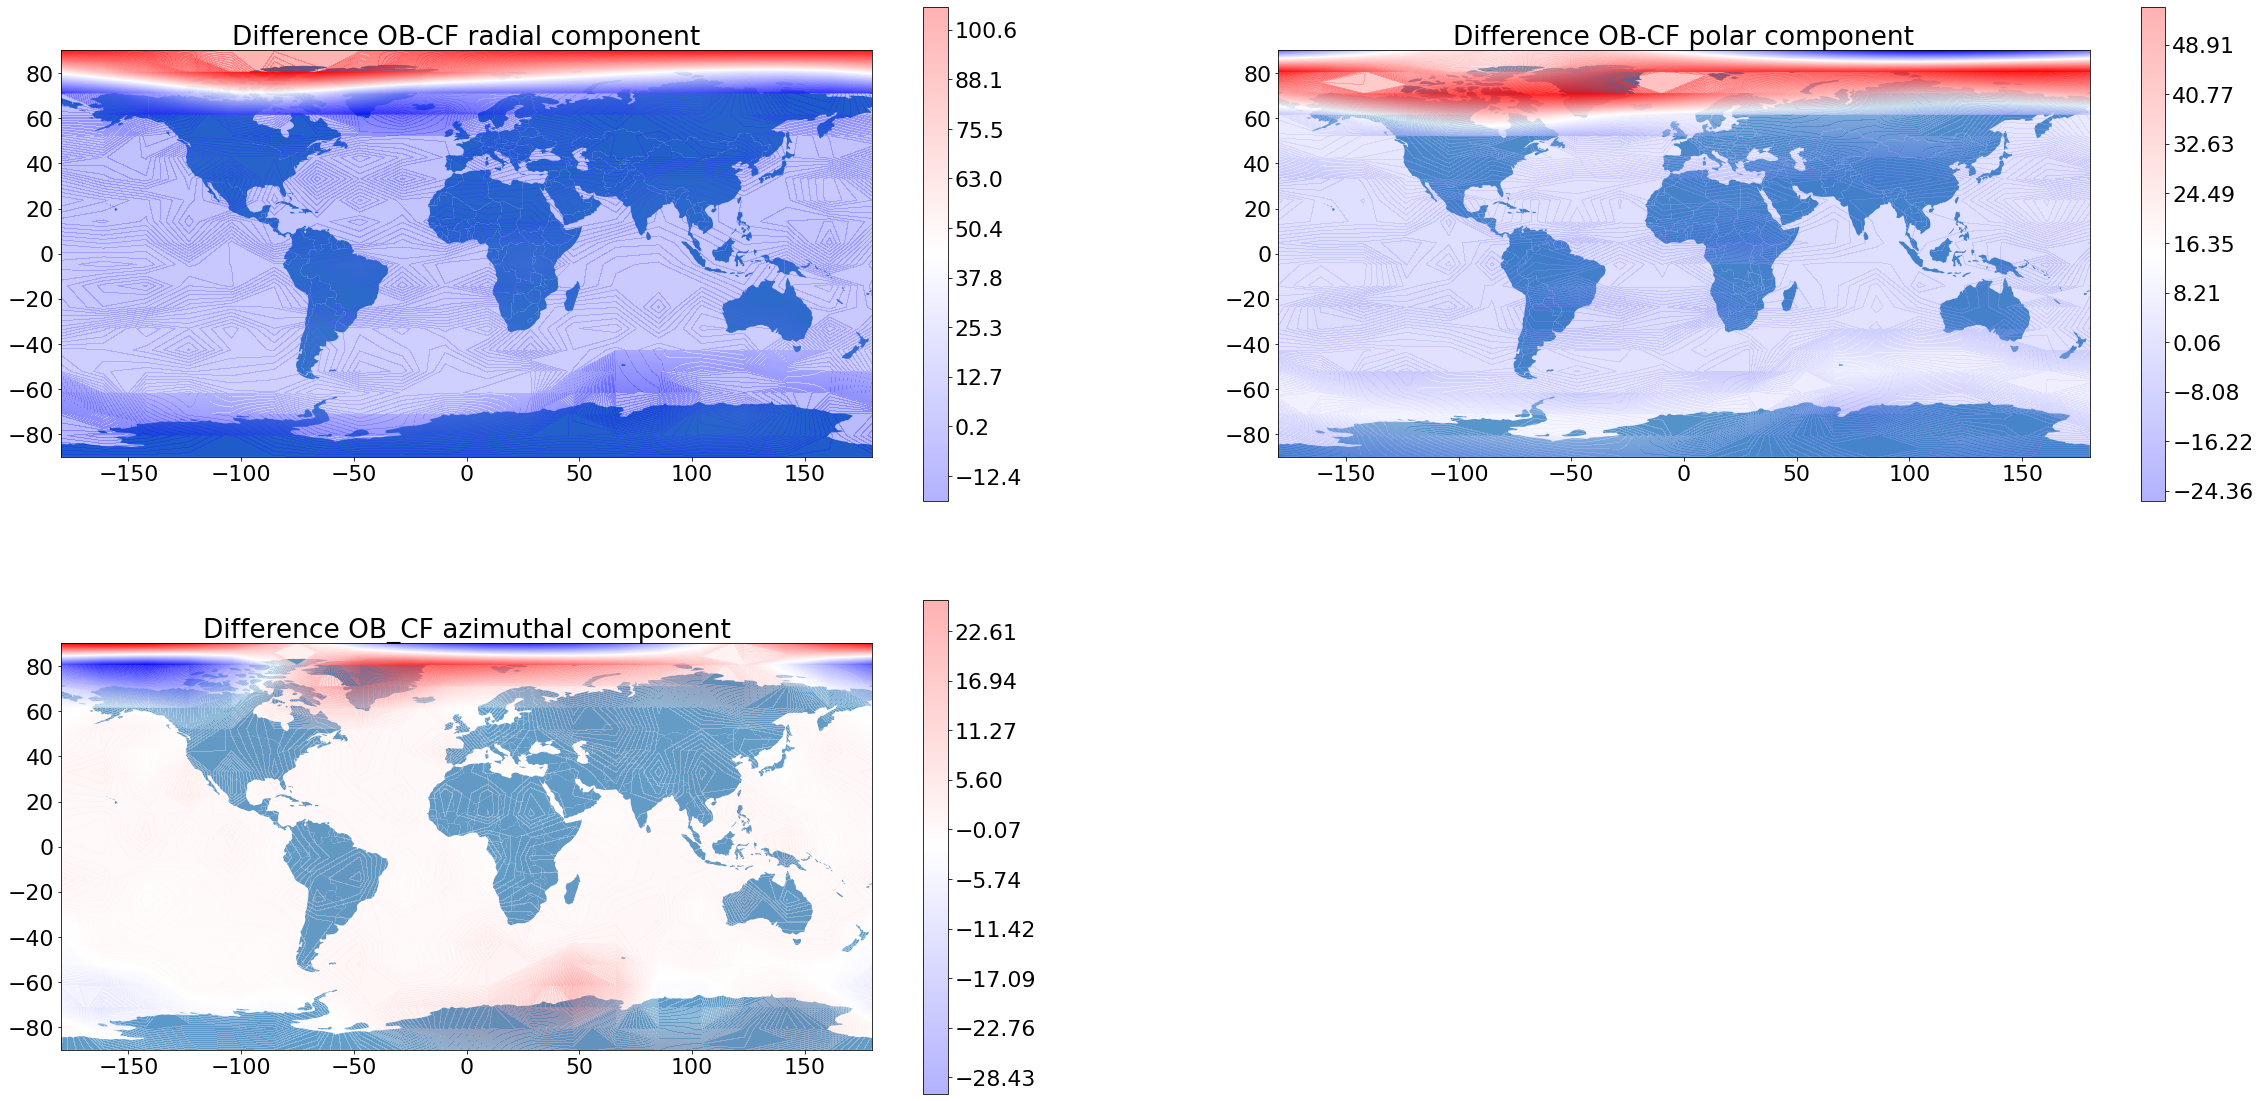

In [9]:
#  Parameters 
date = '2018-09'
radius = 6861
print('unique times list >', unique_times_list)

# Computing the gauss coefficients vectors 
X_CF = compute_gauss_coefs_vector(swarm_file, date, L_max, N_VO, 'B_CF', 'sigma_CF', cm_prior)
X_OB = compute_gauss_coefs_vector(swarm_file, date, L_max, N_VO, 'B_OB', 'sigma_OB', cm_prior)

# Compute B
B_CF = compute_B(positions, N, L_max, X_CF)
B_OB = compute_B(positions, N, L_max, X_OB)
B_difference = (B_OB - B_CF)

#  Lines plotting it
fig = plt.figure(figsize=(40,20))
abs_level = max(np.amin(B_difference), np.amax(B_difference))
levels_B = lambda B: np.linspace(-abs_level, abs_level, N)
BR_meshgrid = compute_B_meshgrid(B_difference, 0, N)
Bth_meshgrid = compute_B_meshgrid(B_difference, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B_difference, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "Difference OB-CF radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Difference OB-CF polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Difference OB_CF azimuthal component")
plt.show()

We can observe that the poles are the regions that have the highest differences between the observed field and the core field, it might be due to external sources. We need to make a deeper study about this phenomenom by studying the differences between the two gauss coefficients matrix. 

### 3.5 Stuying the variations of gauss coefficients over time

We will study the variations of gauss coefficients over time, to do so we will use the observed field and the core field data.

In [6]:
from functions import compute_gauss_coefs_matrix

X_matrix_OB = compute_gauss_coefs_matrix(swarm_file, 13, 300, 'B_OB', 'sigma_OB', cm_prior, unique_times_list)
X_matrix_CF = compute_gauss_coefs_matrix(swarm_file, 13, 300, 'B_CF', 'sigma_CF', cm_prior, unique_times_list)

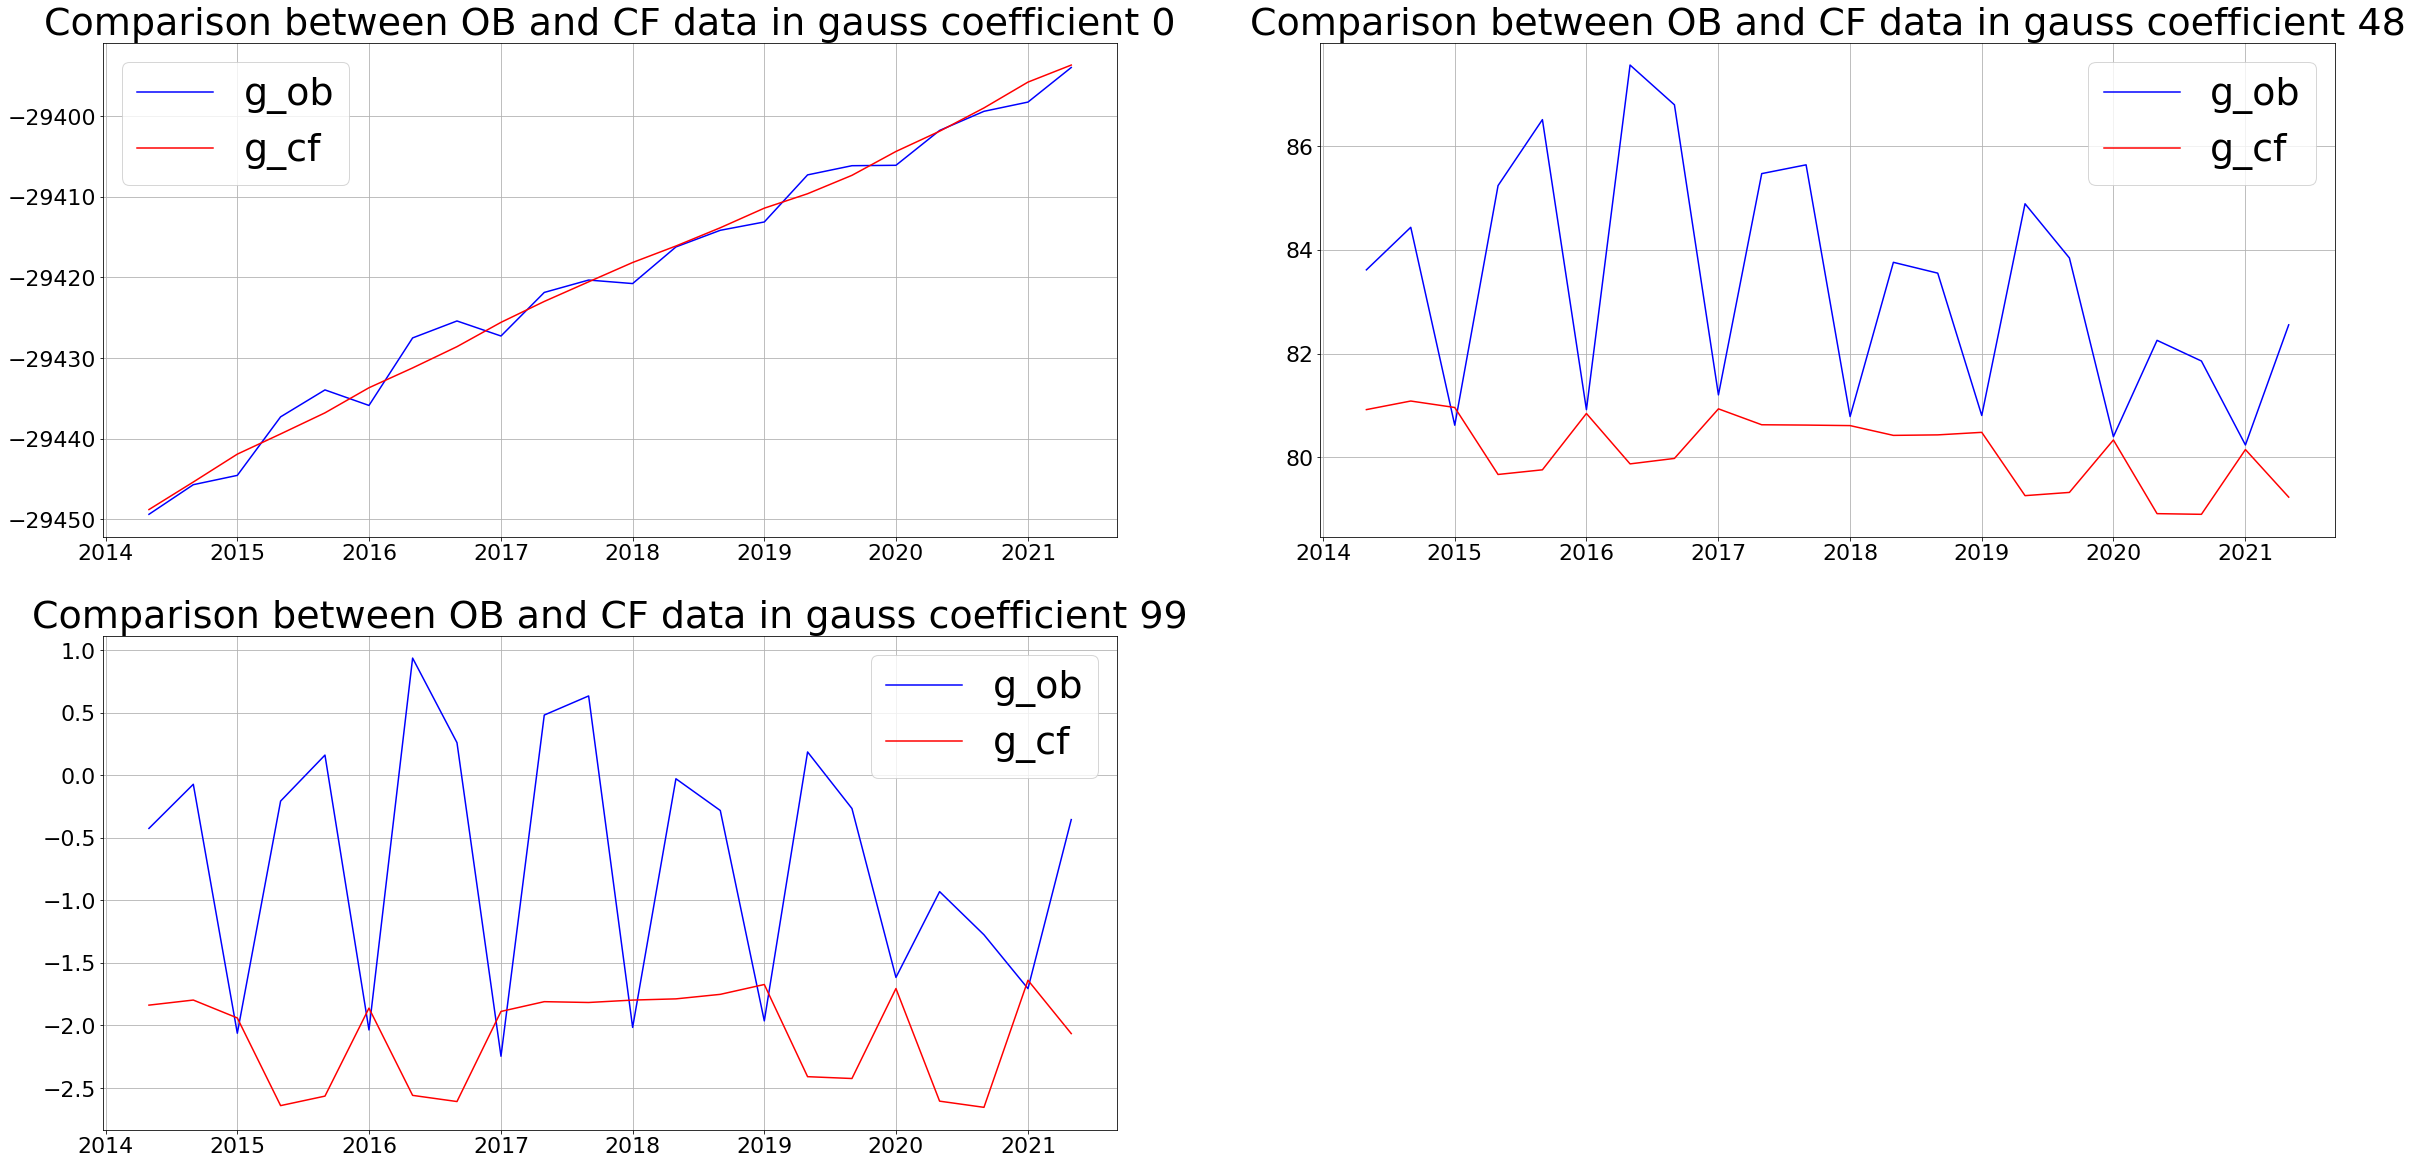

In [7]:
from functions import create_graph_compare_gauss_coefs

fig = plt.figure(figsize=(40,20))
create_graph_compare_gauss_coefs(0, 221, unique_times_list, X_matrix_OB, X_matrix_CF)
create_graph_compare_gauss_coefs(48, 222, unique_times_list, X_matrix_OB, X_matrix_CF)
create_graph_compare_gauss_coefs(99, 223, unique_times_list, X_matrix_OB, X_matrix_CF)
plt.show()

Analysis : We can observe a time dependancy for some of the gauss coefficients. This time dependancy can be explained, the high order gauss coefficients are describing poles with a really thin angular window. Therefore, there are very sensible to smaller contributions for the other sources appart from the core source. The time dependancy is one year, this is partly due to the fact that during the summer, the temperatures rises and therefore the charged particles moves faster. An other explanation that can be made is that during the summer, in poles, the day is permanent and so the measured value depends more of sun contribution. We can see a technical limit there : for now, scientists cannot model the contribution of the sun, so we can't clean its contribution on the geomagnetic field 

### 3.6 Adding an histogram of the different geomagnetic field values

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]
> number of value too far in component 0 :  58
> number of those values with |lats| > 60 :  17
> number of value too far in component 1 :  38
> number of those values with |lats| > 60 :  13
> number of value too far in component 2 :  28
> number of those values with |lats| > 60 :  18


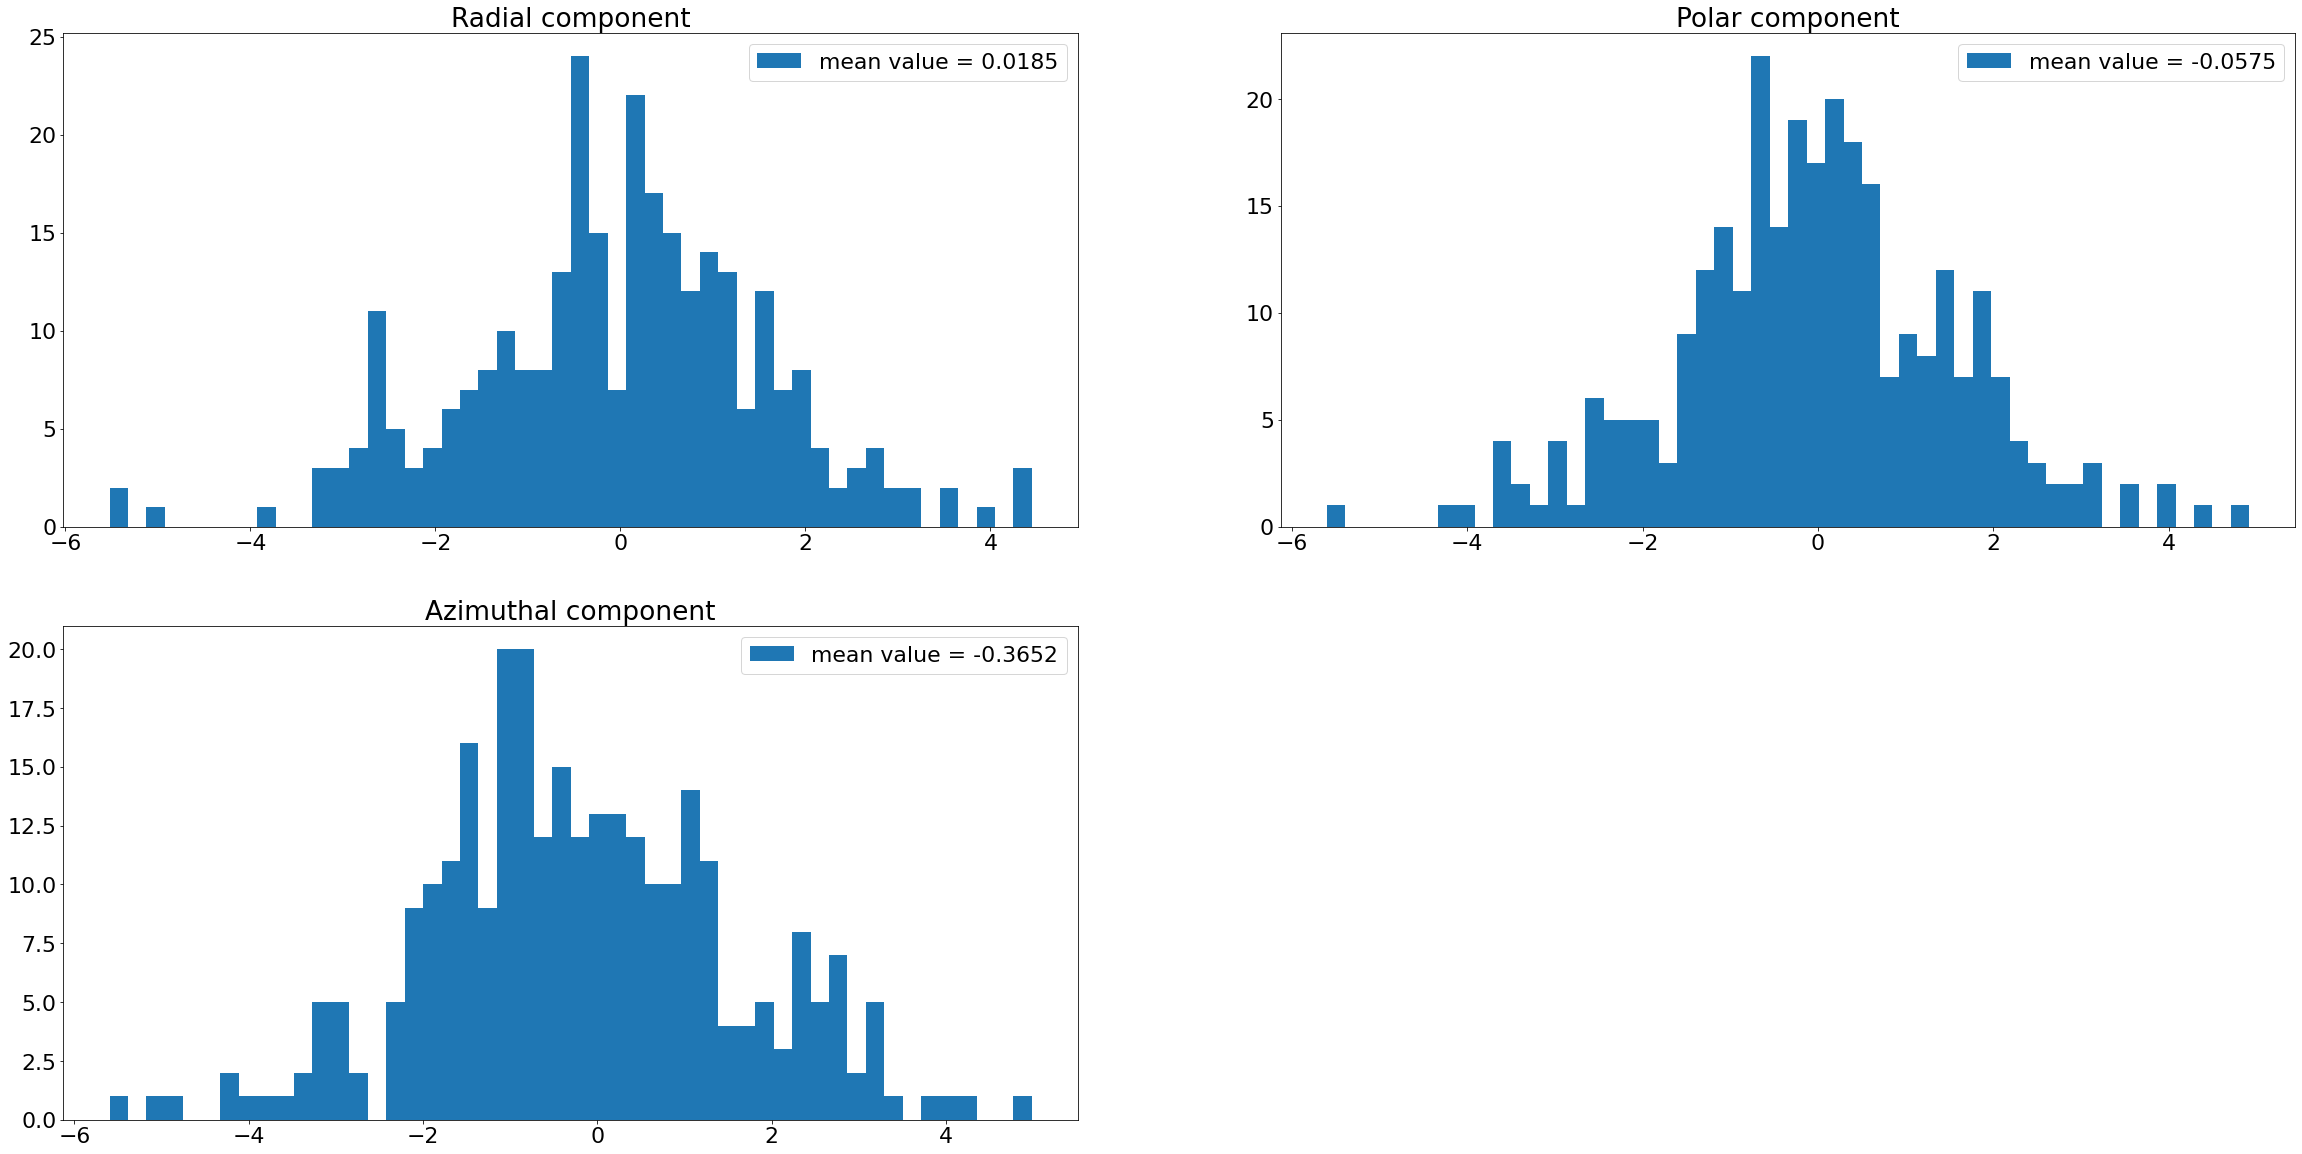

In [8]:
%run functions.py 

## Choice of the date and component
unique_times_list = cdf_times_to_np_date(compute_unique_times_list(alldata['Timestamp']))
print('unique times list >', unique_times_list)
date = '2017-09' # Arbitrary choice of the date to plot 

fig = plt.figure(figsize=(40,20))
create_hist(fig, 0, 221, alldata, L_max, unique_times_list, date, swarm_file, cm_prior, 'Radial component')
create_hist(fig, 1, 222, alldata, L_max, unique_times_list, date, swarm_file, cm_prior, 'Polar component')
create_hist(fig, 2, 223, alldata, L_max, unique_times_list, date, swarm_file, cm_prior, 'Azimuthal component')

plt.show()